In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='YouYuan')

**读取数据**

In [2]:
user_profile = pd.read_csv('./Purchase Redemption Data/user_profile_table.csv')
user_balance_data = pd.read_csv('./Purchase Redemption Data/user_balance_table.csv')
mfd_day_share_interest = pd.read_csv('./Purchase Redemption Data/mfd_day_share_interest.csv')

In [3]:
user_profile.head()

,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座
3,23,1,6411949,双鱼座
4,25,1,6481949,双鱼座


# 数据探索

In [4]:
user_balance_data.head(3)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [5]:
user_balance_data.isnull().sum()

user_id                      0
report_date                  0
tBalance                     0
yBalance                     0
total_purchase_amt           0
direct_purchase_amt          0
purchase_bal_amt             0
purchase_bank_amt            0
total_redeem_amt             0
consume_amt                  0
transfer_amt                 0
tftobal_amt                  0
tftocard_amt                 0
share_amt                    0
category1              2666682
category2              2666682
category3              2666682
category4              2666682
dtype: int64

In [6]:
user_balance_data.shape

(2840421, 18)

有空值得只有category1-4这四个特征，而且占比非常高，在后续处理中如果需要的话基本可以删除掉这四个特征。关键特征total_purchase_amt和total_redeem_amt没有空值

In [7]:
# 转化date到可以读取的类型
user_balance_data['report_date'] = pd.to_datetime(user_balance_data['report_date'], format='%Y%m%d')
# 按照时间排序
user_balance_data_sorted = user_balance_data.sort_values(by=['report_date'], ascending=True)

In [8]:
# 对数据进行按天采样（把purchase和redeem都按天统计求和）
user_balance_data_sorted.index = user_balance_data_sorted['report_date']
user_balance_data_sorted_daily = user_balance_data_sorted[['total_purchase_amt','total_redeem_amt']].resample('D').sum()
user_balance_data_sorted_daily['report_date'] = user_balance_data_sorted_daily.index 

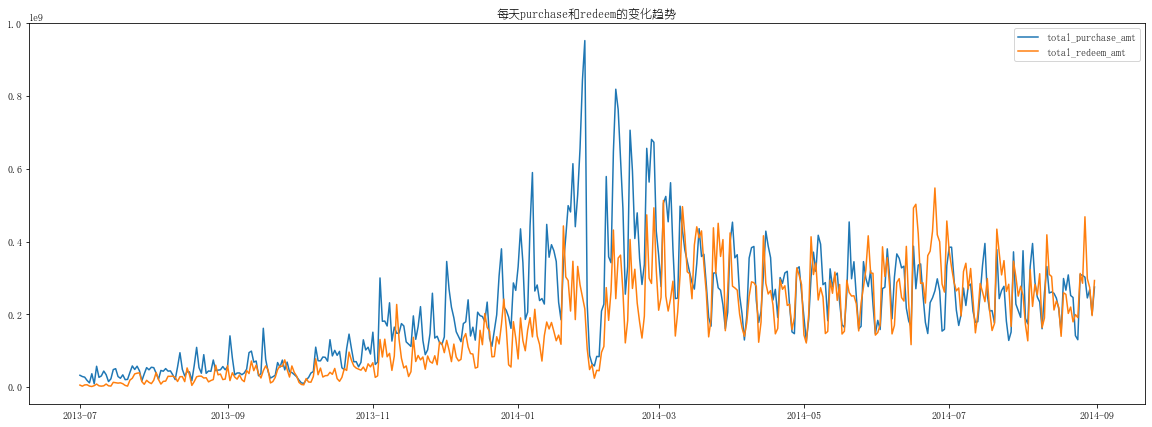

In [9]:
fig = plt.figure(figsize=[20,7])
plt.plot(user_balance_data_sorted_daily.index, user_balance_data_sorted_daily['total_purchase_amt'], label='total_purchase_amt')
plt.plot(user_balance_data_sorted_daily.index, user_balance_data_sorted_daily['total_redeem_amt'], label='total_redeem_amt')
plt.title('每天purchase和redeem的变化趋势')
plt.legend()
plt.show()

明显的在14年5月之后开始出现赎回比购买多了，所以如果要用时间序列的线性模型来建模，最好不用所有数据

# 时间序列预测

## Baseline
### ARIMA
再上图中看得出在2014年1月到3月期间曲线有很大幅度的变化，并且从一个以买入为主的市场转变为以卖出（获利）的市场。由于时间序列以有权重随时间变化的规律，所以我们认为在预测2014年9月的结果时仍然会是卖出为主的情况，预期使用|4-8月作为模型的训练数据来建立模型。

In [10]:
import statsmodels.api as sm

**分析STL**

In [11]:
def plot_stl(data):
    result = sm.tsa.seasonal_decompose(data, freq=30)
    fig = plt.figure(figsize=[12,8])
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    result.trend.plot(ax=ax1, title='Trend')
    result.seasonal.plot(ax=ax2, title='Seasonal')
    result.resid.plot(ax=ax3, title='Residual')
    plt.tight_layout()

<ipython-input-11-c511c7b66ae5>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = sm.tsa.seasonal_decompose(data, freq=30)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


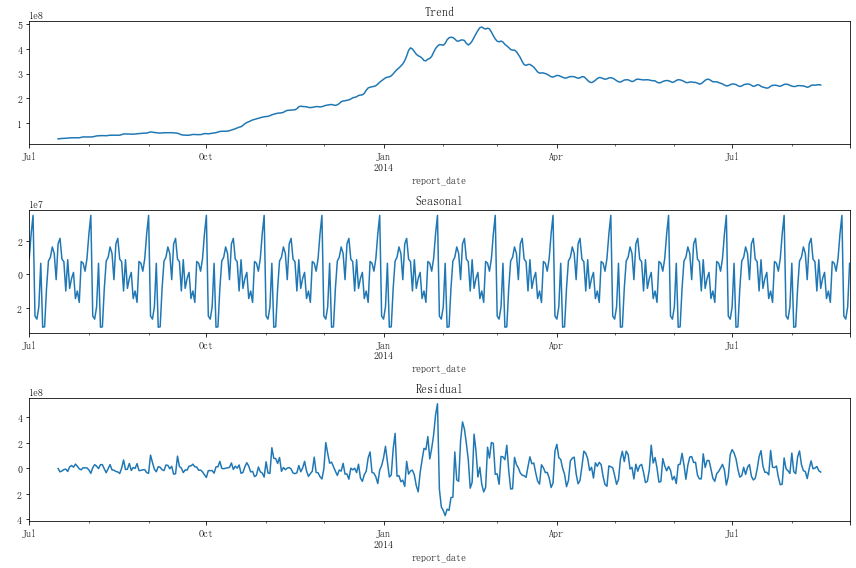

In [12]:
plot_stl(user_balance_data_sorted_daily['total_purchase_amt'])

<ipython-input-11-c511c7b66ae5>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = sm.tsa.seasonal_decompose(data, freq=30)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


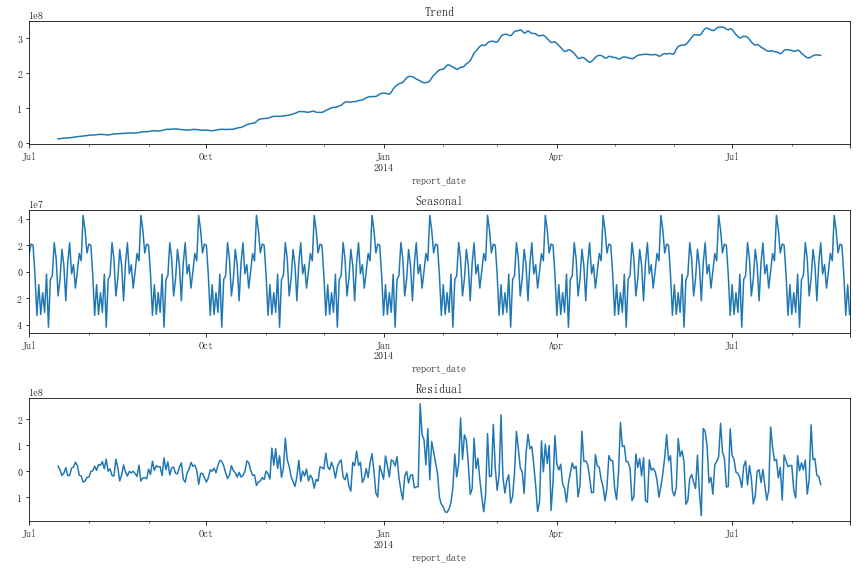

In [13]:
plot_stl(user_balance_data_sorted_daily['total_redeem_amt'])

从STL分解中看出来seasonal还是具有比较强的周期属性。purchase在2014年的2-3月有明显的趋势变化，而redeem在2-3月也出现了明显的抖动，并且purchase的residual项也在同样的时间内出现了剧烈抖动，所以我们只选取14年4-8月的数据

In [14]:
data_stl = user_balance_data_sorted_daily.loc[pd.to_datetime('2014-04-01') : pd.to_datetime('2014-08-31')]
purchase_data = data_stl[['total_purchase_amt']]
redeem_data = data_stl[['total_redeem_amt']]

**ADF校验**:检验序列平稳性，假设purchase不平稳和redeem不平稳  
**purchase模型**

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from itertools import product
from datetime import datetime, timedelta
import warnings
import calendar
from numpy.linalg import LinAlgError

In [16]:
adfuller(purchase_data['total_purchase_amt'])

(-3.007961816542132,
 0.03415752696915146,
 13,
 139,
 {'1%': -3.4782936965183815,
  '5%': -2.882567574015525,
  '10%': -2.5779830117488745},
 5342.858982106029)

purchase可以拒绝原假设, 即平稳，则不做差分，使用ARMA模型

In [21]:
# 设置参数范围
ps = range(0, 8)
qs = range(0, 7)
parameters = product(ps, qs)
parameters_list = list(parameters)
print(parameters_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]


In [22]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(purchase_data['total_purchase_amt'], order=(param[0], param[1])).fit()
    except (ValueError, LinAlgError):
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (1, 4)
参数错误: (1, 5)
参数错误: (1, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (2, 4)
参数错误: (2, 5)
参数错误: (2, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (3, 3)
参数错误: (3, 4)
参数错误: (3, 5)
参数错误: (3, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params 

参数错误: (4, 3)
参数错误: (4, 4)
参数错误: (4, 5)
参数错误: (4, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (5, 2)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (5, 4)
参数错误: (5, 5)
参数错误: (5, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

参数错误: (6, 4)
参数错误: (6, 5)
参数错误: (6, 6)


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

最优模型:                                ARMA Model Results                              
Dep. Variable:     total_purchase_amt   No. Observations:                  153
Model:                     ARMA(7, 6)   Log Likelihood               -2937.622
Method:                       css-mle   S.D. of innovations       49720100.736
Date:                Mon, 18 Jan 2021   AIC                           5905.245
Time:                        16:55:21   BIC                           5950.701
Sample:                    04-01-2014   HQIC                          5923.710
                         - 08-31-2014                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.643e+08    5.8e+06     45.603      0.000    2.53e+08    2.76e+08
ar.L1.total_purchase_amt    -0.6779      0.086     -7.920      0.000      -0.846  

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


最佳参数（7，6），构建未来一个月的预测时间

In [23]:
def add_forecast_period(df, f_month):
    last_month = pd.to_datetime(df.index[len(df)-1])
    date_list = []
    for i in range(f_month):
        year = last_month.year
        month = last_month.month
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
        next_month_days = calendar.monthrange(year, month)[1]
        for day in range(1, next_month_days+1):
            last_month = last_month + timedelta(days=1)
            date_list.append(last_month)
    return date_list

In [24]:
df_sep_p = purchase_data[['total_purchase_amt']]
date_list = add_forecast_period(purchase_data, 1)

In [25]:
# 添加未来要预测的1个月
future_p = pd.DataFrame(index=date_list, columns= purchase_data.columns)
df_sep_p = pd.concat([df_sep_p, future_p])
df_sep_p['forecast'] = best_model.predict(start='2014-04-02', end='2014-09-30', typ='levels')
# 第一个元素不正确，设置为NaN
df_sep_p['forecast'][0] = np.NaN
print(df_sep_p)

           total_purchase_amt      forecast
2014-04-01          453320585           NaN
2014-04-02          355347118  3.371717e+08
2014-04-03          363877120  2.519615e+08
2014-04-04          251895894  2.339115e+08
2014-04-05          202336542  1.943088e+08
...                       ...           ...
2014-09-26                NaN  2.813369e+08
2014-09-27                NaN  1.902740e+08
2014-09-28                NaN  2.313282e+08
2014-09-29                NaN  2.915271e+08
2014-09-30                NaN  3.000403e+08

[183 rows x 2 columns]


<ipython-input-25-10059c243df5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sep_p['forecast'][0] = np.NaN


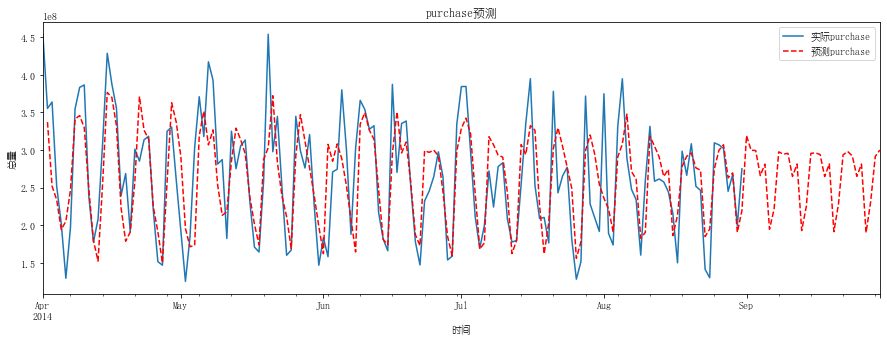

In [26]:
plt.figure(figsize=(15,5))
df_sep_p['total_purchase_amt'].plot(label='实际purchase')
df_sep_p['forecast'].plot(color='r', ls='--', label='预测purchase')
plt.legend()
plt.title('purchase预测')
plt.xlabel('时间')
plt.ylabel('总量')
plt.show()

In [27]:
purchase_pred = df_sep_p['2014-09']

**redeem模型**

In [28]:
adfuller(redeem_data['total_redeem_amt'])

(-2.2152746344140475,
 0.20074842690444245,
 14,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 5394.847483570603)

t值大于三个临界值，无法拒绝原假设，不平稳，做一阶差分

In [29]:
diff1 = redeem_data.diff(1)
adfuller(diff1[1:])

(-12.421887928311946,
 4.11945340656229e-23,
 5,
 146,
 {'1%': -3.4759527332353084,
  '5%': -2.881548071241103,
  '10%': -2.577438765246763},
 5359.89589560754)

一阶差分结果的t值小于三个临界值，可以拒绝原假设，平稳

In [30]:
# 设置参数范围
ps = range(0, 4)
qs = range(0, 4)
parameters = product(ps, qs)
parameters_list = list(parameters)
print(parameters_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [31]:
results_r = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model_r = ARIMA(redeem_data['total_redeem_amt'],order=(param[0], 1, param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model_r.aic
    if aic < best_aic:
        best_model_r = model_r
        best_aic = aic
        best_param_r = param
    results_r.append([param, model_r.aic])
print('redeem最优模型: ', best_model_r.summary())

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params 

redeem最优模型:                               ARIMA Model Results                              
Dep. Variable:     D.total_redeem_amt   No. Observations:                  152
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2961.696
Method:                       css-mle   S.D. of innovations       68282065.128
Date:                Mon, 18 Jan 2021   AIC                           5937.391
Time:                        16:57:15   BIC                           5958.559
Sample:                    04-02-2014   HQIC                          5945.990
                         - 08-31-2014                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.021e+05   1.07e+06      0.095      0.924      -2e+06    2.21e+06
ar.L1.D.total_redeem_amt     1.2478      0.005    249.238      0.000       1

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


redeem最优模型（2，1，3）

In [32]:
# 添加未来要预测的1个月
df_sep_r = redeem_data[['total_redeem_amt']] 
future_r = pd.DataFrame(index=date_list, columns= redeem_data.columns)
df_sep_r = pd.concat([df_sep_r, future_r])

In [33]:
df_sep_r['forecast'] = best_model_r.predict(start='2014-04-02', end='2014-09-30', typ='levels')
# 第一个元素不正确，设置为NaN
df_sep_r['forecast'][0] = np.NaN

<ipython-input-33-9b16ecbe581e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sep_r['forecast'][0] = np.NaN


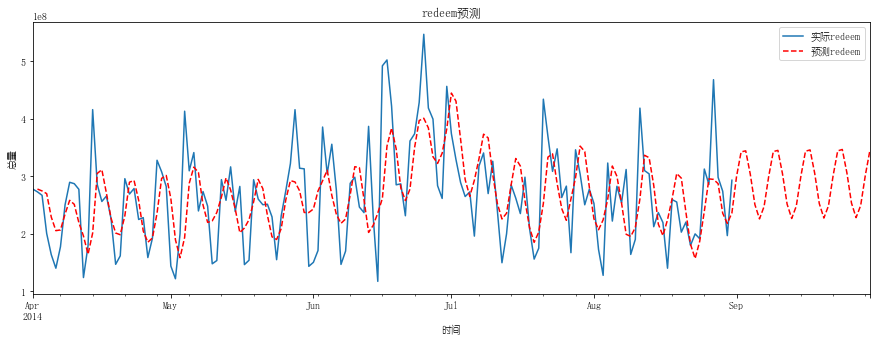

In [34]:
plt.figure(figsize=(15,5))
df_sep_r['total_redeem_amt'].plot(label='实际redeem')
df_sep_r['forecast'].plot(color='r', ls='--', label='预测redeem')
plt.legend()
plt.title('redeem预测')
plt.xlabel('时间')
plt.ylabel('总量')
plt.show()

In [35]:
redeem_pred = df_sep_r['2014-09']

**保存结果**

In [38]:
result = pd.DataFrame()
result['report_date'] = purchase_pred.index
result['purchase'] = purchase_pred.forecast.values
result['redeem'] = redeem_pred.forecast.values

In [39]:
result['report_date'] = result['report_date'].apply(lambda x: str(x).replace('-','')[:8]) # 把时间表示改回原来的形式
result.to_csv('tsa_base.csv', header=None, index=None)